<a href="https://colab.research.google.com/github/tiskutis/EuromonitorInternational/blob/main/Euromonitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
You are given a training set for product type classification. The task is to build a model to predict the
column label, using the other columns as input.

Column explanations:
- sku_id – product id
- country_name – name of the country in which the product was found
- retailer – name of the retailer in which the product was found
- breadcrumbs – breadcrumbs, where breadcrumbs show the path of the product in the retailer
taxonomy tree
- breadcrumbs_t – translated breadcrumbs
- name – name of the product
- name_t – translated name
- pack_size – pack size field of the product
- pack_size_t – translated pack size
- description_short – product description, possibly truncated to keep maximum length fixed
- description_t_short – translated description
- resnet50_labels_005 – categories predicted by an image classifier, thresholded at 0.05
confidence, joined with '~'
- resnet50_labels_06 – categories predicted by an image classifier, thresholded at 0.6 confidence
- price – price of the product in USD
- label – product type, this is the target to predict

Keep in mind that some of the columns can contain noisy information and the translations are
automatic. You do not have to use all the input columns to build a model.
# Evaluation Criteria
Your model will be evaluated based on:
- Exploratory data analysis
- Feature engineering
- Machine learning fundamentals
- Coding standards

Ideally, your solution should consist of a notebook that explores the data, builds and validates the
model with clear reasons why you made specific choices.



#Exploratory data analysis and feature engineering

In [ ]:
!pip install emoji pytorch-lightning transformers scikit-multilearn neptune-client

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import emoji
import string
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from skmultilearn.model_selection import iterative_train_test_split

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Euromonitor/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Euromonitor/test.csv')

In [4]:
df_train.head(3)

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","[""""Beauty & Personal Care"""",""""Tools & Accessor...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","[""""Free From"""",""""Free From Chilled & Meat"""",""""...",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7


In [5]:
df_train.shape

(3983, 16)

Since this is a NLP task and time recommended to spend on it is approximately 4 hours, there is not much time for experimentation with different models and/or data preprocessing approaches. I will try to complete this task intuitively using first ideas that come to my mind after seeing the dataset. 

Train dataset consists of 3983 rows with 16 columns, of which most important after first glance are these: breadcrumbs_t, name_t and description_t_short. _t here means that text is automatically translated, because original text contains not only english, but also russian, chinese etc. I think that these three columns contain all of the textual information I might need. Country_name and retailer are also text-based, but they look like categories to me. Still, it might be feasible to experiment with models incorporating these two columns into the text corpus and look for improvements in scores, but for now I will leave them and proceed with aforementioned three columns. Resnet labels could also be promising, but after looking into it I decided not to include them, because some of these labels in my opinion are misleading (e.g. yoghurt labeled as suncream). I will rely on pure text.

In [19]:
def autolabel(bar_plot) -> None:
    """
    Attach a text label above each bar displaying its height
    """
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

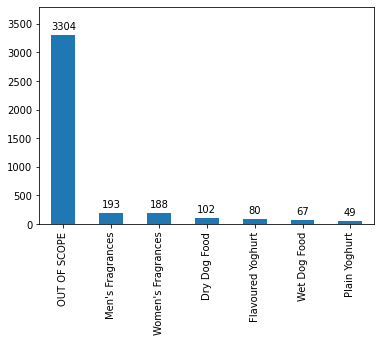

In [30]:
ax = df_train['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.ylim(0,3800)
autolabel(ax)

As can be seen from picture above, this dataset is severely imbalanced. It seems that the three main things this dataset works with are fragrances, dog food and yoghurt. However, the majority of values in this dataset are called OUT OF SCOPE, which means they are unrelated to any of the three. I will take a random sample of 200 rows from OUT OF SCOPE category to balance the dataset. Working with the original dataset would yield very good classification scores, but since majority of guesses would be on OUT OF SCOPE category, the results would reflect the underlying bias issue such model would have. 

I will divide the dataset into two subsets - one of them contains only minority categories and other - out of scope category with 200 random rows. Then I will concatenate both subsets into one and shuffle it with the help of sample(frac=1).

In [32]:
df_temp_not_out_of_scope = df_train[df_train['label_id']!=1]
df_temp_out_of_scope = df_train[df_train['label_id']==1].sample(n=200)
df_train_new = pd.concat([df_temp_not_out_of_scope, df_temp_out_of_scope]).sample(frac=1).reset_index(drop=True)

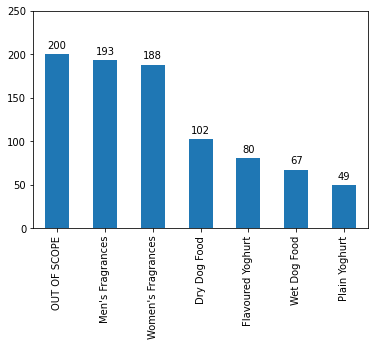

In [34]:
ax = df_train_new['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.ylim(0,250)
autolabel(ax)

This seems to be better. Next step is to put  information from three relevant columns (name, breadcrumbs and description) into one chunk of text, which will be cleaned from excessive information with helper functions described below.

In [42]:
sp = spacy.load('en_core_web_sm')


def concatenate_text(row: pd.core.series.Series) -> pd.core.series.Series:
  """
  This method takes breadcrumbs_t, description_t_short and name_t columns from
  provided row and joins them together into a new column, called 'text_data'.
  """
  text_parts = [row['breadcrumbs_t'], 
              row['description_t_short'],
              row['name_t']]

  row['text_data'] = ' '.join([text_part for text_part in text_parts 
                               if text_part is not np.nan])
  return row


def clean_text(text: str) -> str:
    """
    This method lowers all words, removes all links, removes paragraph breaks,
    removes digits, removes multiple spaces and removes punctuation signs.
    """

    text = text.lower() 
    text = re.sub("https?://\S+|www\.\S+", "", text)  
    text = re.sub("\n", " ", text) 
    text = re.sub("\w*\d\w*", "", text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(" {2,}", " ", text)  
    return text


def remove_stopwords(text: str, sp) -> str:
    """
    This method removes stopwords from the text.
    """
    text_tokens = word_tokenize(text)
    tokens_without_sw= [word for word in text_tokens if not word in sp.Defaults.stop_words]

    return " ".join(tokens_without_sw)


def expand_contracted_expressions(text: str) -> str:
    """
    This method substitutes most common contracted expressions with full ones.
    """
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"aren't","are not",text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"couldn't","could not",text)
    text = re.sub(r"didn't","did not",text)
    text = re.sub(r"doesn't","does not",text)
    text = re.sub(r"don't","do not",text)
    text = re.sub(r"hadn't","had not",text)
    text = re.sub(r"hasn't","has not",text)
    text = re.sub(r"haven't","have not",text)
    text = re.sub(r"he'd","he would",text)
    text = re.sub(r"he'll","he will",text)
    text = re.sub(r"he's","he is",text)
    text = re.sub(r"i'd","I would",text)
    text = re.sub(r"i'd","I had",text)
    text = re.sub(r"i'll","I will",text)
    text = re.sub(r"i'm","I am",text)
    text = re.sub(r"isn't","is not",text)
    text = re.sub(r"it's","it is",text)
    text = re.sub(r"it'll","it will",text)
    text = re.sub(r"i've","I have",text)
    text = re.sub(r"let's","let us",text)
    text = re.sub(r"mightn't","might not",text)
    text = re.sub(r"mustn't","must not",text)
    text = re.sub(r"shan't","shall not",text)
    text = re.sub(r"she'd","she would",text)
    text = re.sub(r"she'll","she will",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"shouldn't","should not",text)
    text = re.sub(r"that's","that is",text)
    text = re.sub(r"there's","there is",text)
    text = re.sub(r"they'd","they would",text)
    text = re.sub(r"they'll","they will",text)
    text = re.sub(r"they're","they are",text)
    text = re.sub(r"they've","they have",text)
    text = re.sub(r"we'd","we would",text)
    text = re.sub(r"we're","we are",text)
    text = re.sub(r"weren't","were not",text)
    text = re.sub(r"we've","we have",text)
    text = re.sub(r"what'll","what will",text)
    text = re.sub(r"what're","what are",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"what've","what have",text)
    text = re.sub(r"where's","where is",text)
    text = re.sub(r"who'd","who would",text)
    text = re.sub(r"who'll","who will",text)
    text = re.sub(r"who're","who are",text)
    text = re.sub(r"who's","who is",text)
    text = re.sub(r"who've","who have",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"wouldn't","would not",text)
    text = re.sub(r"you'd","you would",text)
    text = re.sub(r"you'll","you will",text)
    text = re.sub(r"you're","you are",text)
    text = re.sub(r"you've","you have",text)
    text = re.sub(r"'re"," are",text)
    text = re.sub(r"wasn't","was not",text)
    text = re.sub(r"we'll"," will",text)
    text = re.sub(r"didn't","did not",text)
    text = re.sub(r"tryin'","trying",text)
    text = text.strip(' ')

    return text

In [43]:
df_train_new = df_train_new.apply(concatenate_text, axis=1)
df_train_new.text_data = df_train_new.text_data.apply(expand_contracted_expressions)
df_train_new.text_data = df_train_new.text_data.apply(clean_text)
df_train_new.text_data = df_train_new.text_data.apply(remove_stopwords, sp=sp)

In [46]:
df_train_new.text_data.head()

0    cool dairy products yogurt spoon enjoy creamy ...
1    dairy eggs juice yogurts multipacks informatio...
2    pet shop dogs foods ration royal canin ration ...
3    scents water scent compositioncompositionanana...
4    home perfumery women perfumes brand calvin kle...
Name: text_data, dtype: object

One more thing before going to machine learning part - new column with text lengths. Let's see how text lengths are distributed.

In [47]:
df_train_new['text_length'] = df_train_new.text_data.apply(lambda x: len(x))

(0.0, 500.0)

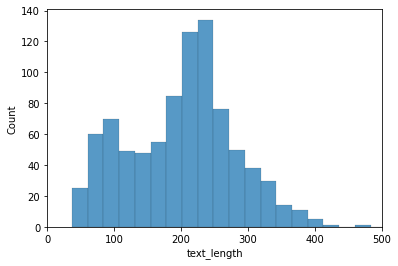

In [51]:
sns.histplot(data=df_train_new, x="text_length")
plt.xlim(0, 500)

In [52]:
df_train_new.text_length.describe()

count     879.000000
mean      208.312856
std       244.576332
min        37.000000
25%       137.000000
50%       212.000000
75%       249.500000
max      7055.000000
Name: text_length, dtype: float64

From describe() function above we can see that at upper percentile (75%) text length is 249,5. This information is important for the upcoming model, because I will have to decide max sequence lenght that model accepts. Setting this value too high can lead to RAM overflow issues and too low might lead to a significant loss of information. However, seeing that at leat 75% of texts are at 250 or lower length, I can choose my max sequence lenght to be 256 as a sweet spot between performance and information loss. 

#Machine learning

This is multinomial classification task so the current representation of target value is not convenient. Let's one-hot encode it.

In [53]:
df_train_new = pd.get_dummies(df_train_new, columns = ['label_id'], prefix='')

In [54]:
df_train_new.head(3)

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,text_data,text_length,_1,_2,_3,_4,_5,_6,_7
0,138335303,Austria,Billa,"[""""Kühlwaren"""",""""Milchprodukte"""",""""Joghurt""""]","[""""cool were"""",""""dairy products"""",""""yogurt""""]",Ja! Natürlich Sommerfrisch Bio-Guave Fruchtjog...,yes! naturally Sommerfrisch Bio-guava fruit yo...,200 Gramm Becher,200 gram mug,löffeln und genießen: für das cremige bio-jo...,spoon and enjoy: for the creamy bio-yogurt bec...,bucket~paper_towel,NaN,0.779976,Flavoured Yoghurt,cool dairy products yogurt spoon enjoy creamy ...,174,0,0,0,0,0,1,0
1,12539432,United Kingdom,sainsburys,"[""""Dairy, eggs & juice"""",""""Yogurts"""",""""Multipa...","[""""Dairy, eggs & juice"""",""""Yogurts"""",""""Multipa...","Alpro Yogurt Alternative Blackcurrant, Elderfl...","Alpro Yogurt Alternative Blackcurrant, Elderfl...",NaN,NaN,information description fermented soya product...,information description fermented soya product...,nipple~packet~paper_towel~strawberry~vending_m...,NaN,2.397515,Flavoured Yoghurt,dairy eggs juice yogurts multipacks informatio...,270,0,0,0,0,0,1,0
2,57160696,Brazil,Submarino,"[""""Pet Shop"""",""""Cães"""",""""Alimentos"""",""""Ração""""]","[""""Pet Shop"""",""""dogs"""",""""foods"""",""""ration""""]",Royal Canin Hypoallergenic Small 2kg,Royal Canin Hypoallergenic Small 2kg,NaN,NaN,a ração royal canin canine veterinary diet h...,the royal canin ration canine veterinary diet ...,can_opener~packet~paper_towel~plastic_bag~soap...,NaN,18.643160,Dry Dog Food,pet shop dogs foods ration royal canin ration ...,213,0,1,0,0,0,0,0


Each of the existing labels now have its own column with value being either 0 or 1. 1 means that that label is the correct one for that row and everything else is 0. Now features and labels will be split into train and validation subsets with the help of iterative train test (validation in this case) split. Since there are some differences in category quantities, main idea behind iterative split is to try to keep the existing balance for train and validation subsets. It might not be perfect, but at least split is not random.

In [56]:
targets = ["_1", "_2","_3", "_4", "_5", "_6", "_7"]

features = df_train_new[["text_data"]]
labels = df_train_new[targets]

X_train, y_train, X_val, y_val = iterative_train_test_split(
    features.values, labels.values, test_size=0.2
)

X_train = pd.DataFrame(X_train, columns=features.columns)
X_val = pd.DataFrame(X_val, columns=features.columns)
y_train = pd.DataFrame(y_train, columns=labels.columns)
y_val = pd.DataFrame(y_val, columns=labels.columns)

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

## Model and data preparation

For this task my choice is RoBERTa model. Of course, using deep learning on such a small dataset might seem like a bit of an overkill, but using transfer learning in the past seemed to be fun and in most cases it went well, besides, I would imagine that dataset for this task is a small part of huge flows of data Euromonitor has to deal with every day. With the increase in amount of data, deep learning approach seems to be more favored, so I continue with scalability in mind. 

Code for processing data samples can get messy and hard to maintain, so I want my dataset code to be decoupled from my model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow me to use pre-loaded datasets as well as my own data. Dataset stores the samples and their corresponding labels and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

A custom Dataset class must implement three functions: init, len, and getitem.

- The init function is run once when instantiating the Dataset object. In this case passed dataframe is initialized.
- The len function returns the number of samples in our dataset.
- The get_item function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the sample's location in the dataframe, takes idx'th row, separates features from target variable and returns them in a form of dictionary.

In [58]:
class ProductDescription(Dataset):


    def __init__(self, df: pd.DataFrame, max_sequence_length: int = 256):
        self.tokenizer =  RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)
        self.df = df
        self.max_sequence_length = max_sequence_length
        self.targets = ["_1", "_2","_3", "_4", "_5", "_6", "_7"]
        

    def __len__(self) -> int:
        return len(self.df)


    def __getitem__(self, idx) -> dict:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        encoded = self.tokenizer.encode_plus(
            text=self.df.loc[idx, "text_data"],                      
            add_special_tokens = True, 
            max_length = self.max_sequence_length,
            padding = 'max_length',
            return_attention_mask = True,
            pad_to_max_length = False,
            truncation = True,
            return_tensors = 'pt',
        )
        
        encoded = {k:v.squeeze(0) for k,v in encoded.items()}
        
        try:
            labels = self.df.loc[idx, self.targets]
            encoded['label'] = torch.FloatTensor(labels)
            return encoded
        
        except:
            return encoded

In [ ]:
example = ProductDescription(df_train)[0]
assert "input_ids" in example.keys()
assert "attention_mask" in example.keys()
assert "label" in example.keys()
assert isinstance(example['input_ids'], torch.Tensor)

Classifier will be built using Pytorch Lightning. PyTorch Lightning is a library that provides a high-level interface for PyTorch and helps organize code as well as reduces boilerplate. By abstracting away engineering code, it makes deep learning experiments easier to reproduce and improves developer productivity.



In [62]:
class ProductClassifier(pl.LightningModule):

    
    def __init__(self):
      super().__init__()
      config = RobertaConfig.from_pretrained("roberta-base", num_labels=7)
      self.model = RobertaForSequenceClassification.from_pretrained("roberta-base", 
                                                                    config=config)
      self.lr = 1e-3
      self.criterion = torch.nn.BCELoss()
      self.batch_size = 32
      self.base_grad(requires_grad = False)

        
    def base_grad(self, requires_grad: bool) -> None:
      """
      This method is used for enabling of disabling gradients for the model.
      """
      for param in self.model.base_model.parameters():
          param.requires_grad = requires_grad


    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: torch.Tensor = None):
      """
      This method sends data through neural network and receives predictions.
      If provided labels are not None, loss is calculated and returned with
      predictions. If labels are None, only predictions are returned.
      """
      predictions = self.model(input_ids, attention_mask=attention_mask, return_dict=True)
      predictions = torch.sigmoid(predictions.logits)
      if labels is not None:
          loss = self.criterion(predictions, labels)
          return loss, predictions
      return predictions

    
    def training_step(self, batch: dict, batch_idx: int) -> dict:
      """
      This method receives batch information during training phase and sends 
      it to forward method, which gives back loss and prediction values.
      """
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      labels = batch["label"]
      loss, predictions = self(input_ids, attention_mask, labels)

      return {"loss": loss, "predictions": predictions, "labels": labels}

    
    def validation_step(self, val_batch: dict, batch_idx: int) -> dict:
      """
      This method receives batch information during validation phase and sends 
      it to forward method, which gives back loss and prediction values.
      """
      input_ids = val_batch["input_ids"]
      attention_mask = val_batch["attention_mask"]
      labels = val_batch["label"]
      loss, predictions = self(input_ids, attention_mask, labels)
      
      return {"val_loss": loss, "predictions": predictions, "labels": labels}

    
    def configure_optimizers(self) -> torch.optim.Optimizer:
      """
      This method is required by the framework to setup optimizer for the model.
      """
      optimizer = torch.optim.Adam(self.parameters(), 
                                    lr=self.lr)
      return optimizer
    
    
    def train_dataloader(self) -> DataLoader:
      """
      This method sets up the training data with help of Dataset class. Data is 
      then wrapped with DataLoader class, which provides iterable and sends data
      in batches. 
      """
      dataset = ProductDescription(df_train)
      loader = DataLoader(dataset, 
                          batch_size=self.batch_size, 
                          shuffle=True, 
                          num_workers=2)
      
      return loader
    
    
    def val_dataloader(self) -> DataLoader:
      """
      This method sets up the validation data with help of Dataset class. Data 
      is then wrapped with DataLoader class, which provides iterable and sends
      data in batches. 
      """
      dataset = ProductDescription(df_val)
      loader = DataLoader(dataset, 
                          batch_size=self.batch_size, 
                          shuffle=False, 
                          num_workers=2)
      
      return loader
    
    
    def training_epoch_end(self, outputs: dict) -> None:
      """
      Contains the outputs of the training_step, collected for all batches 
      over the epoch.
      Tracks the progress of the entire epoch by calculating average loss.
      """
      avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
      neptune_logger["train_loss"].log(avg_loss)


    def validation_epoch_end(self, outputs: dict) -> None:
      """
      Contains the outputs of the validation_step, collected for all batches 
      over the epoch.
      Tracks the progress of the entire epoch by calculating average loss.
      """
      avg_loss = torch.stack([output["val_loss"] for output in outputs]).mean()
      neptune_logger["val_loss"].log(avg_loss)

## Training

In [63]:
def train(model, epochs: int, lr: float) -> pl.Trainer:
    """
    Models' learning rate is set to provided value, pl.Trainer object is 
    initiated and model is fit. Returns trainer object, which contains trained
    model.
    """
    model.lr = lr
    trainer = pl.Trainer(max_epochs=epochs, 
                         gpus=torch.cuda.device_count())
    trainer.fit(model)

    return trainer


def train_and_save(train_epochs: int = 10, 
                   finetune_epochs: int = 10, 
                   train_lr: float = 1e-3,  
                   finetune_lr: float = 1e-5) -> None:
    """
    Initializes the model and trains it for provided number of epochs.
    After training gradients are enabled for finetuning for provided number of
    finetune epochs. After finetuning model is saved locally.
    """
    model = ProductClassifier()
    train(model, epochs=train_epochs, lr=train_lr)
    model.base_grad(True)
    trainer = train(model, epochs=finetune_epochs, lr=finetune_lr)

    trainer.save_checkpoint('RobertaModel')

The majority of this project is done in google colab, however, there are some ongoing issues on this platform with gpu usage and runtime connection, so I trained the model on Kaggle platform and downloaded it into my google drive. Since model is not trained here, I will provide train and validation loss graph instead.

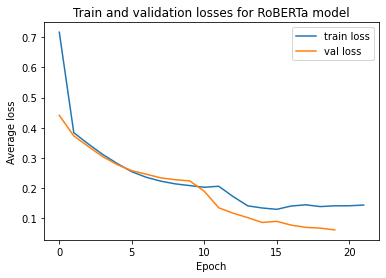

In [66]:
with open('/content/gdrive/MyDrive/Euromonitor/val_loss EI.csv', 'r') as f:
  with open('/content/gdrive/MyDrive/Euromonitor/train_loss EI.csv', 'r') as g:

    lines_val = f.readlines()
    lines_train = g.readlines()
    x1 = [float(line.split(",")[0]) for line in lines_val]
    x2 = [float(line.split(",")[0]) for line in lines_train]
    y1 = [float(line.split(",")[2]) for line in lines_val]
    y2 = [float(line.split(",")[2]) for line in lines_train]

plt.plot(x1, y1, label="train loss")
plt.plot(x2, y2, label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title("Train and validation losses for RoBERTa model")
plt.legend(loc="upper right")
plt.show()

## Testing

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ProductClassifier().load_from_checkpoint("/content/gdrive/MyDrive/Euromonitor/RobertaModel")
model.eval().to(device)

Test data processing is similar to train - concatenate text and clean it. After cleaning, data is set up with the help of Dataset class and wrapped by Dataloader. After these steps data is ready to be accepted by the classifier. 

In [68]:
df_test = df_test.apply(concatenate_text, axis=1)
df_test.text_data = df_test.text_data.apply(expand_contracted_expressions)
df_test.text_data = df_test.text_data.apply(clean_text)
df_test.text_data = df_test.text_data.apply(remove_stopwords, sp=sp)

In [69]:
test_loader = DataLoader(ProductDescription(df_test), batch_size=32, shuffle=False, num_workers=2)

In [70]:
y_pred = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        predictions = model(batch["input_ids"], batch["attention_mask"])
        y_pred.append(predictions)

After predictions are made, they are sent to cpu if they were on gpu device. Predictions are in the form of a tensor with torch.Size([7]) - 7 elements (that is how many categories there are available for prediction). Since these elements are probabilities of category being the right one, we choose the highest value with torch.argmax() function and retrieve the index value. Because index counting begins at 0 and the lowest category number is 1, we have to shift all predictions by +1. After doing so predictions are ready to be put into csv and submitted for evaluation.

In [71]:
y_preds = torch.cat(y_pred).to('cpu')

In [80]:
y_preds = [int(torch.argmax(y_pred)+1) for y_pred in y_preds]

In [83]:
template = pd.read_csv('/content/gdrive/MyDrive/Euromonitor/test_pred_template.csv')
template.set_index('sku_id', inplace=True)
template['label_id'] = y_preds
template.head()

,label_id
sku_id,
193691,4
194042,1
225668,1
351205,1
374160,1


In [84]:
template.to_csv('/content/gdrive/MyDrive/Euromonitor/predictions.csv')